In [513]:
import numpy as np
import os
from CoPhaser import utils
from CoPhaser import plotting
import sys

sys.path.insert(0, "../set_up")  # add set_up path to search list

import plot_helpers
import constants

from scipy.stats import pearsonr
from scipy.sparse import csr_matrix, hstack, vstack

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

import anndata
import scanpy as sc
import pickle
import pandas as pd

In [514]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [515]:
DATA_FOLDER = "../figure_2/data"

height_ratios_scaling: [1, 1, 1]


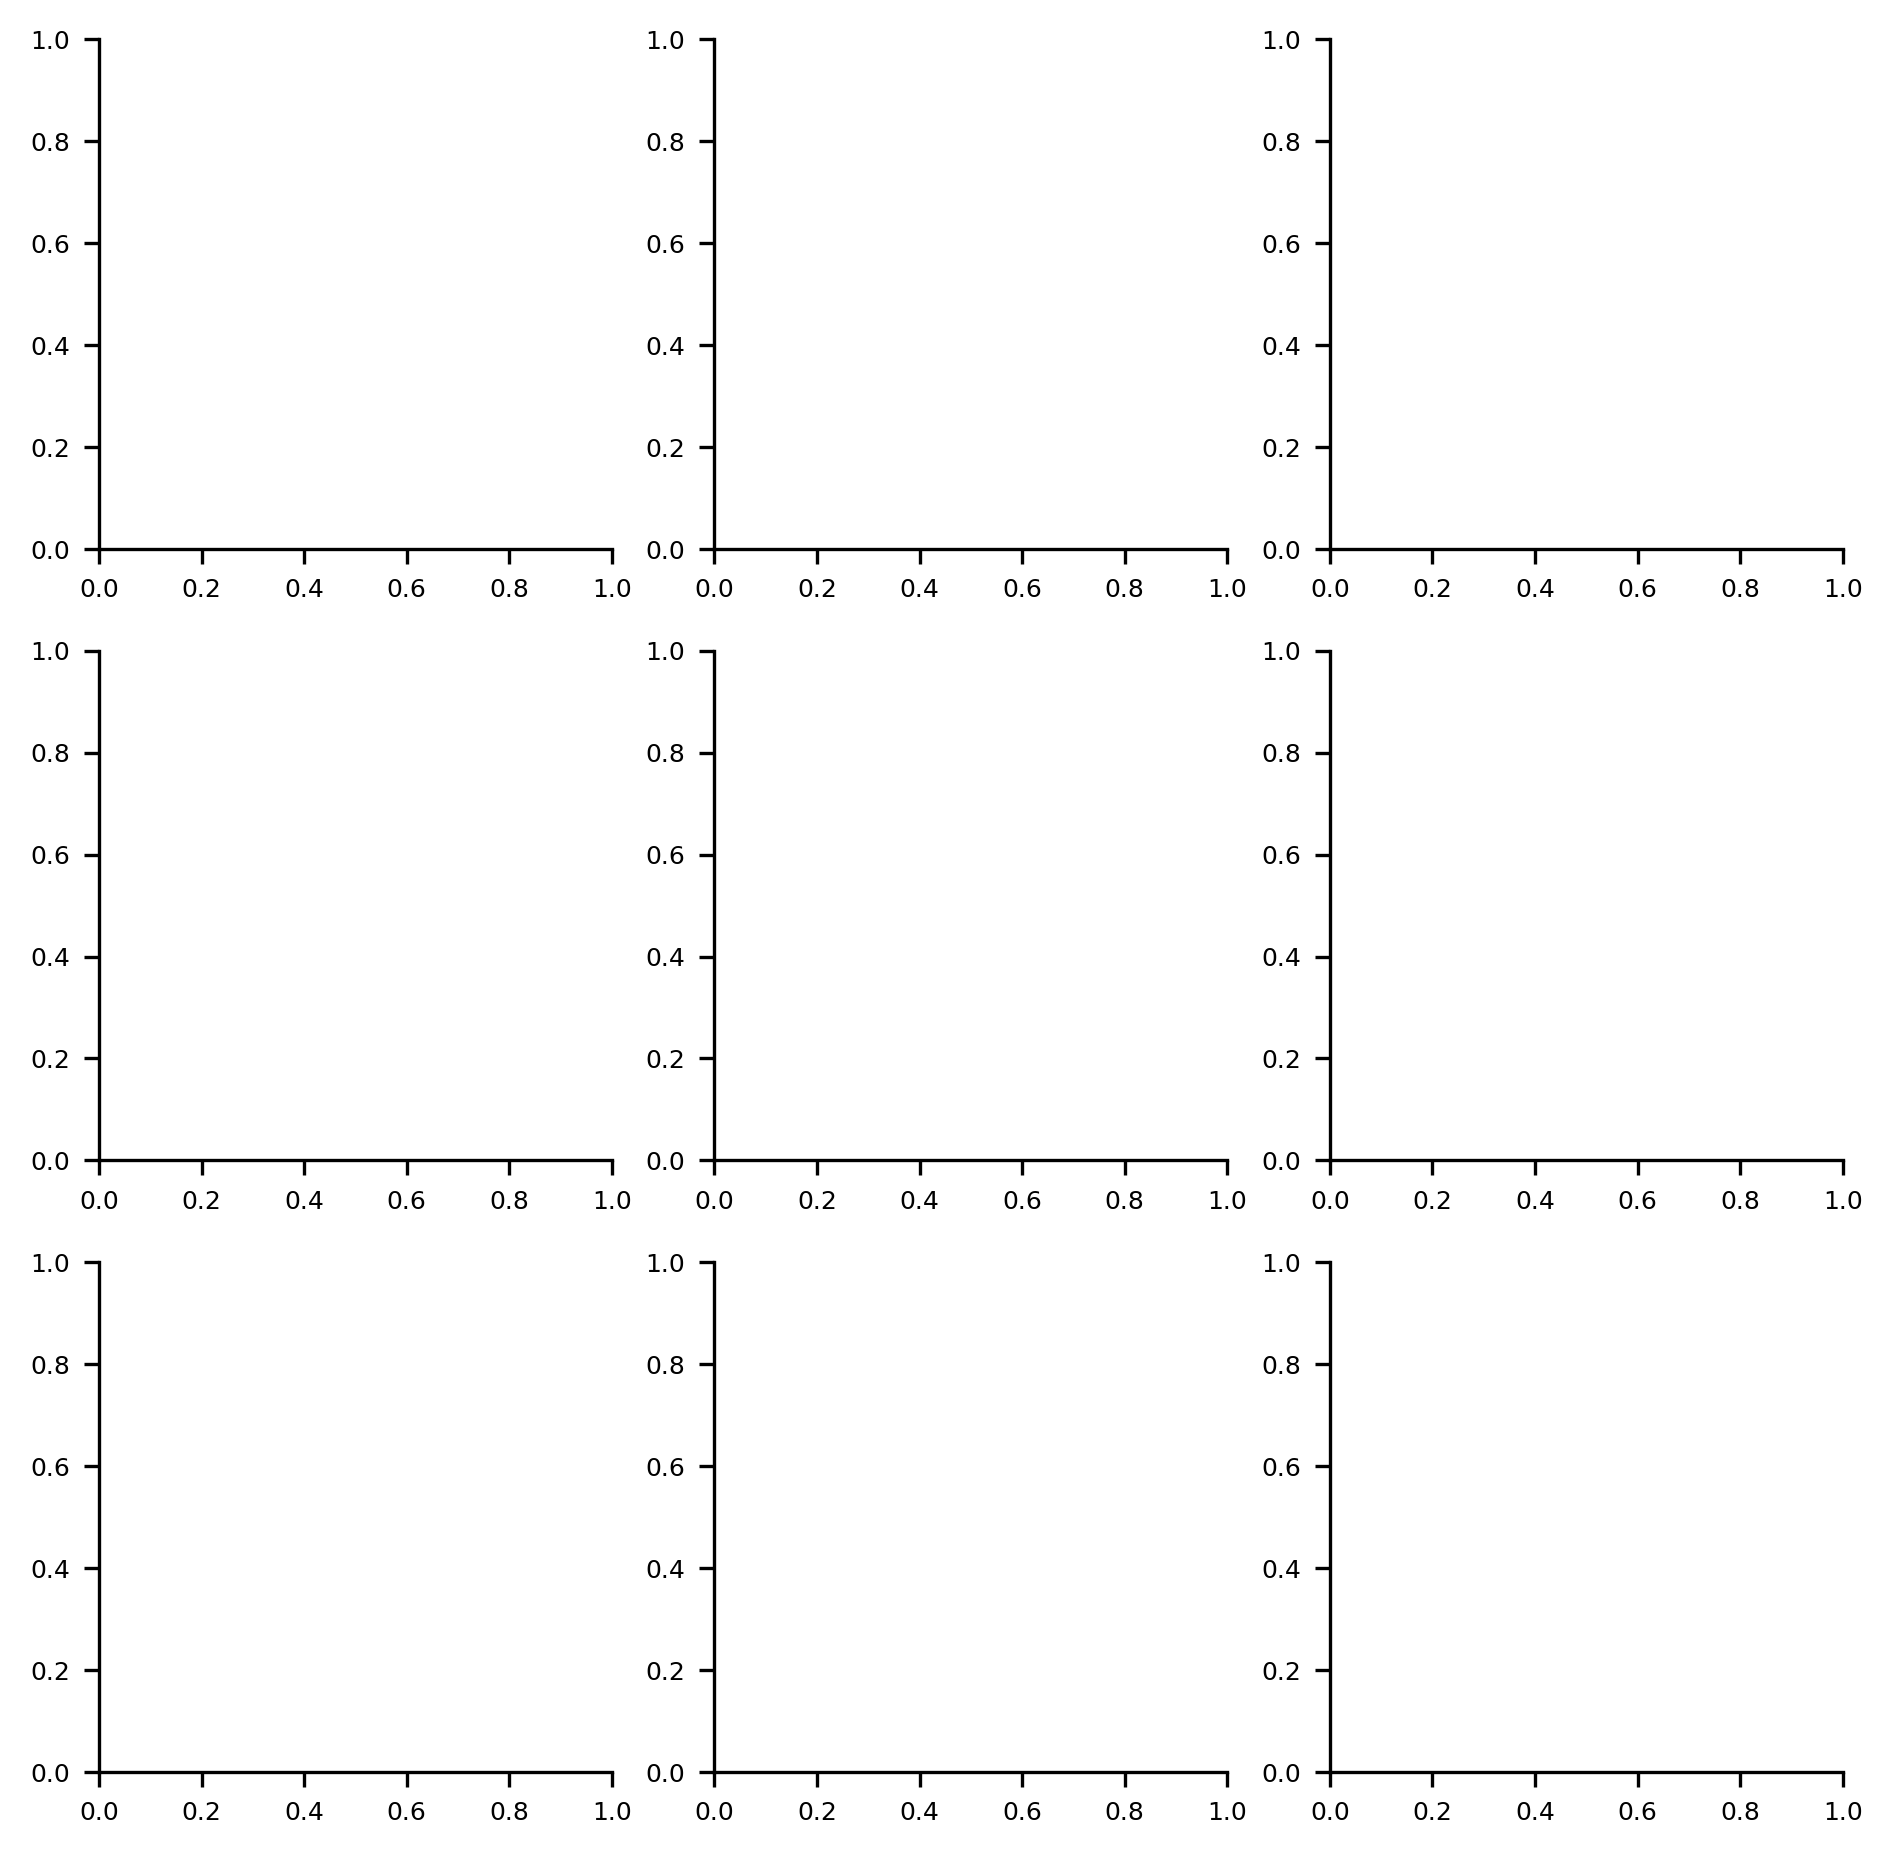

In [516]:
mosaic = [["A", "B", "C"], ["D", "E", "F"], ["G", "H", "I"]]
fig, axs = plot_helpers.create_pannels(mosaic=mosaic, h_pad=0)

In [517]:
vasa = pickle.load(open(os.path.join(DATA_FOLDER, "vasa_res.pkl"), "rb"))
vasa

{'embedding': array([[-1.7479428, 11.770438 ],
        [12.535977 , 11.360967 ],
        [ 2.099037 , 12.784089 ],
        ...,
        [ 3.0999982, 14.994775 ],
        [ 9.211832 ,  2.7688165],
        [12.046578 , 11.078278 ]], dtype=float32),
 'phases': 0        1.353041
 1        2.813054
 2        2.478801
 3       -3.133023
 4        2.018315
            ...   
 46117   -0.826039
 46118    1.380422
 46120   -0.822513
 46121    0.450558
 46123   -2.350754
 Name: inferred_theta, Length: 38913, dtype: float32,
 'author_labels': 0          NaN
 1          NaN
 2         True
 3          NaN
 4         True
          ...  
 46117    False
 46118     True
 46120    False
 46121      NaN
 46123     True
 Name: S-phase, Length: 38913, dtype: object,
 'JS_res': {'Our Method': [0.8359352851362121],
  'UMAP': [0.473721231194144],
  'Cyclop': [0.12634239067230416],
  'Velo\nCycle': [0.07434213701886656],
  'random': 0.03631005697217307,
  'Tricycle': [0.1515010546695972],
  'PCA': [0.444775

In [518]:
vasa["phases"] = utils.normalize_angles(vasa["phases"] - 0.1 * np.pi)

In [519]:
ax = axs["A"]
sns.scatterplot(
    x=vasa["embedding"][:, 0],
    y=vasa["embedding"][:, 1],
    hue=vasa["author_labels"],
    alpha=0.3,
    edgecolor=None,
    s=5,
    ax=ax,
)
ax.set_title("z Space")
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
leg = ax.get_legend()
if leg is not None:
    for lh in leg.legend_handles:
        lh.set_alpha(1)

In [520]:
ax = axs["B"]
plotting.modify_axis_labels(ax=ax, axis="x", step=0.5)
plotting.plot_smoothed_profiles(
    vasa["phases"],
    vasa["histones"] * 1e4,
    ax=ax,
    xlabel="Phase",
    ylabel="Normalized Counts",
    title="Histones Expression",
)
ax.set_ylim(bottom=0)

(0.0, 16.65983299739953)

In [521]:
axs = plot_helpers.make_polar(axs, "C")
plotting.plot_cell_cycle(vasa["df_rhythmic"], ax=axs["C"], shift=-0.1 * np.pi)

/home/maxine/Documents/paychere/cell_cycle_VAE_Fourrier_model/src/CoPhaser/plotting.py:232: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


In [522]:
def plot_distribution_s_phase(
    ax,
    phases,
    s_phase_annotation=vasa["author_labels"],
    offset=-np.pi,
    xlabel="Phase",
    legend=True,
    title="S Phase Distribution",
):
    plotting.modify_axis_labels(ax=ax, axis="x", step=0.5)
    sns.histplot(
        x=utils.normalize_angles(phases + offset),
        bins=50,
        hue=s_phase_annotation,
        stat="density",
        common_norm=False,
        ax=ax,
        legend=legend,
    )
    ax.set_xlabel(xlabel)
    JS_distance = utils.get_jensenshannon_raw(phases, s_phase_annotation)
    # ax.text(0.6, 0.95, f"JS D: {JS_distance:.2f}", transform=ax.transAxes, va="top")
    ax.set_title(f"{title} (JS D:{JS_distance:.2f})")

In [523]:
DATA_FOLDER

'../figure_2/data'

In [524]:
seurat_results = pd.read_csv(DATA_FOLDER + "/seurat_cellcycle_scores_all_cells.csv")
annotation_seurat = seurat_results["Phase"]
annotation_seurat.name = "Seurat Phase"
ax = axs["G"]

from scipy.spatial.distance import jensenshannon

probs = pd.crosstab(
    vasa["author_labels"].values, annotation_seurat.values, normalize="index"
)
js_score = jensenshannon(probs.iloc[0], probs.iloc[1])

sns.histplot(
    hue=annotation_seurat,
    x=vasa["author_labels"].values,
    discrete=True,
    multiple="dodge",
    shrink=0.8,
    stat="density",
    common_norm=False,
    ax=ax,
)

ax.set_xlabel("Original Authors Annotation")
ax.set_xticks([0, 1])
ax.set_xticklabels(["Other", "S"])
ax.set_title(f"Seurat (JS D:{js_score:.2f})")

Text(0.5, 1.0, 'Seurat (JS D:0.06)')

In [525]:
plot_distribution_s_phase(
    axs["I"],
    vasa["phases"],
    vasa["author_labels"],
    offset=0,
    xlabel="Inferred Phase",
    legend=True,
    title="Our Model",
)

In [526]:
plot_distribution_s_phase(
    axs["H"],
    vasa["df_rhythmic"]["pca_theta"].values,
    vasa["author_labels"],
    xlabel="PC1,2",
    offset=-np.pi,
    legend=True,
    title="PCA",
)

In [527]:
# plot_distribution_s_phase(
#     axs["K"],
#     vasa["PCA_celltype_corrected_phase"],
#     vasa["author_labels"],
#     offset=0.75 * np.pi,
#     xlabel="PC1,3 CT Corrected Phase",
# )

In [528]:
vasa

{'embedding': array([[-1.7479428, 11.770438 ],
        [12.535977 , 11.360967 ],
        [ 2.099037 , 12.784089 ],
        ...,
        [ 3.0999982, 14.994775 ],
        [ 9.211832 ,  2.7688165],
        [12.046578 , 11.078278 ]], dtype=float32),
 'phases': 0        1.038882
 1        2.498895
 2        2.164642
 3        2.836004
 4        1.704155
            ...   
 46117   -1.140198
 46118    1.066262
 46120   -1.136672
 46121    0.136399
 46123   -2.664914
 Name: inferred_theta, Length: 38913, dtype: float32,
 'author_labels': 0          NaN
 1          NaN
 2         True
 3          NaN
 4         True
          ...  
 46117    False
 46118     True
 46120    False
 46121      NaN
 46123     True
 Name: S-phase, Length: 38913, dtype: object,
 'JS_res': {'Our Method': [0.8359352851362121],
  'UMAP': [0.473721231194144],
  'Cyclop': [0.12634239067230416],
  'Velo\nCycle': [0.07434213701886656],
  'random': 0.03631005697217307,
  'Tricycle': [0.1515010546695972],
  'PCA': [0.444775

In [529]:
# adata = anndata.read_h5ad("../data/cellcycle_maxine/RPE_37C_Rep1_full.h5ad")
DATA_FOLDER_ADATA = "../../../data/"
adata = anndata.read_h5ad(
    f"{DATA_FOLDER_ADATA}cellcycle_maxine/VASA_preprocesseed.h5ad"
)
adata

AnnData object with n_obs × n_vars = 38913 × 16011
    obs: 'Cell_ID', 'obs_names', 'Stage', 'Dataset', 'G0?', 'UMAP_phase', 'UMI_SUM', 'S-phase', 'Celltype', 's_counts', 'u_counts', 'percent_unspliced', 'total_counts', 'pca_theta'
    var: 'var_names', 'Type', 'n_cells'
    uns: 'log1p'
    layers: 'matrix', 's_log', 's_norm', 'spliced', 'u_log', 'u_norm', 'unspliced'

In [530]:
def get_gene_fractions(gene_name, adata, layer="spliced"):
    library_size = adata.layers[layer].sum(axis=1)
    library_size = np.array(library_size).flatten()
    gene_fractions = (
        adata[:, gene_name].layers[layer].toarray().flatten() / library_size
    )
    return gene_fractions


def get_genes_fractions(genes_name, adata, layer="spliced"):
    library_size = adata.layers[layer].sum(axis=1)
    library_size = np.array(library_size).flatten()[:, np.newaxis]
    gene_fractions = adata[:, genes_name].layers[layer].toarray() / library_size
    return gene_fractions

,Anln,Anp32e,Atad2,Aurka,Aurkb,Birc5,Blm,Brip1,Bub1,Casp8ap2,...,Ttk,Tubb4b,Tyms,Ube2c,Ubr7,Uhrf1,Ung,Usp1,Wdr76,cell_types
0,0.273445,-0.187551,-0.103234,-0.375690,-0.199890,-0.139400,-0.102646,0.047724,-0.188120,-0.170969,...,0.085775,-0.147955,0.033438,-0.149666,-0.238888,-0.248476,-0.654914,-0.316878,-0.385986,Unknown
1,-0.334420,0.223879,0.138870,-0.154196,-0.072020,-0.019545,0.063765,0.154226,0.137461,0.184896,...,-0.143631,-0.152031,-0.031263,-0.363330,0.168406,0.237721,0.200444,0.264507,0.395416,Unknown
2,-0.085598,0.089679,0.084371,-0.410834,-0.208410,-0.229993,0.026278,-0.158239,0.013491,0.108866,...,-0.016407,-0.381948,0.098688,-0.183010,-0.194805,-0.024513,-0.216992,0.002643,-0.104196,Intermediate Mesoderm I
3,0.179585,-0.375816,-0.206629,-0.319538,-0.287543,0.203362,-0.416984,-0.558696,0.027889,-0.046770,...,-0.027265,-0.143839,-0.250845,-0.340980,-0.279583,-0.466095,-0.738178,-0.130013,-0.761559,Unknown
4,-0.179654,0.226540,0.105083,-0.516811,-0.205511,-0.316843,0.137098,0.207705,0.154700,0.001291,...,-0.012426,-0.394353,0.173300,-0.472486,-0.137438,0.214788,-0.427645,-0.294773,-0.326673,Paraxial Mesoderm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38908,-0.099593,0.068740,0.055121,-0.411225,-0.189895,-0.203053,-0.002994,-0.232295,0.002048,0.078884,...,0.005642,-0.414156,0.128388,-0.095313,-0.238565,-0.092386,-0.179491,0.021458,-0.066854,Intermediate Mesoderm I
38909,-0.126134,0.210962,0.092949,-0.565136,-0.234279,-0.281287,0.089748,0.132660,0.147320,0.019731,...,0.001988,-0.510344,0.127048,-0.318192,-0.295299,0.172287,-0.512577,-0.235569,-0.192461,Paraxial Mesoderm
38910,-0.113976,0.156898,0.080492,-0.309895,-0.080786,-0.139015,0.000763,0.105732,0.084379,0.086573,...,-0.107622,-0.424263,0.049124,-0.330215,-0.147703,0.021461,-0.215058,0.006752,0.078144,Somites
38911,-0.060598,0.004363,-0.043413,-0.394476,-0.287988,-0.260230,-0.003406,-0.035707,-0.030313,0.102492,...,0.104855,-0.066494,0.111067,-0.161299,-0.186377,-0.131112,-0.132186,-0.157529,-0.125353,Unknown


cell_types
Endothelium                                                1129
Epiblast (E7.5)                                            1172
Spinal cord (differentiated neurons)                       2209
Unknown                                                    8793
Paraxial Mesoderm                                          1617
Caudal Epiblast                                            1421
Somites                                                    1631
Forebrain                                                  1111
Preplacodal/Placosal Region                                1138
Forebrain/Hindbrain (Isthmus)                              1122
Rhombomeres (Hindbrain)                                    1085
Lateral Plate Mesoderm/Intermediate Mesoderm Primordium    1324
Intermediate Mesoderm I                                    1597
Name: count, dtype: int64

Text(0.5, 1.0, 'Predicted Δμ')

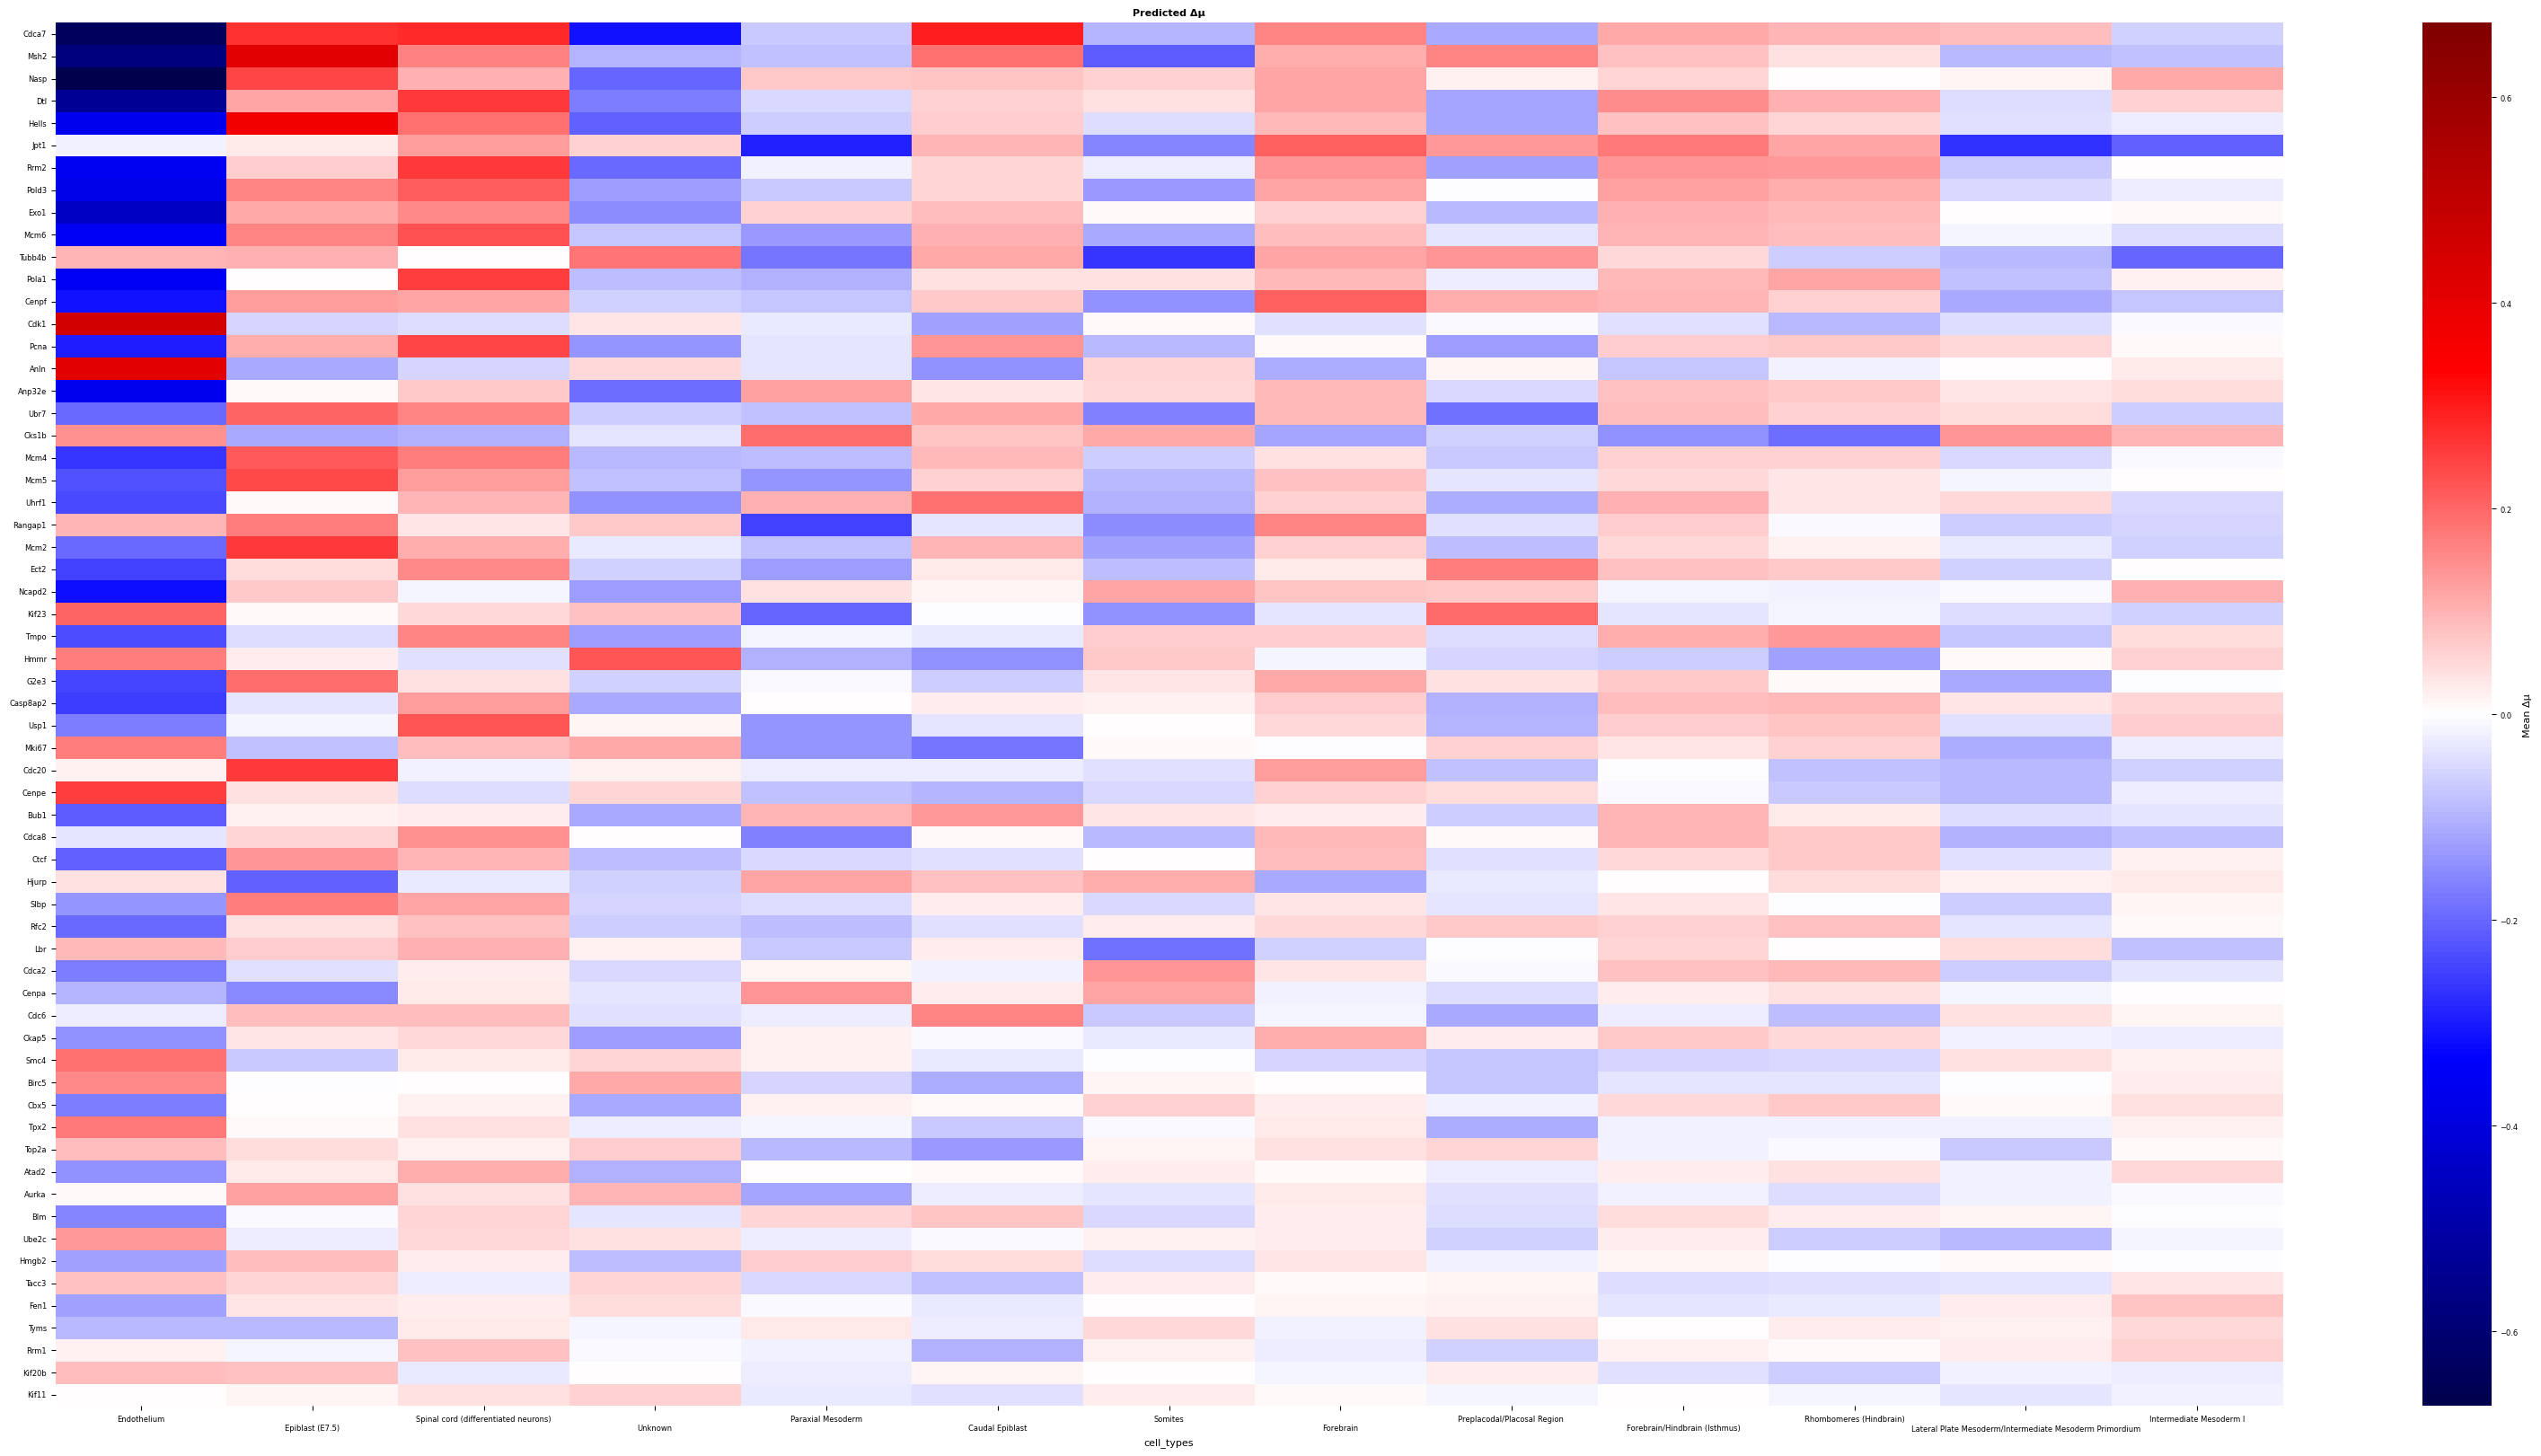

In [531]:
# clock genes
from CoPhaser import gene_sets

cycling_genes = list(gene_sets.SMALL_CELL_CYCLE_GENE_SET)
df_to_plot = vasa["df_z"][cycling_genes].copy()
df_to_plot["cell_types"] = vasa["cell_types"].astype(str).values
# keep only cell types with more than 1000 cells, for robustness
n_cells = df_to_plot["cell_types"].value_counts()
n_cells = n_cells[n_cells > 1000]
n_cells = n_cells.drop("Erythropoiesis (expansive, S-phase)")
df_to_plot = df_to_plot[df_to_plot["cell_types"].isin(n_cells.index)]
# drop Erythropoiesis (expansive, S-phase) since mostly in S-phase
df_to_plot = df_to_plot
n_cells = df_to_plot["cell_types"].str.strip().value_counts()
# keep only genes a fraction of counts of at least 1e-4
fractions = get_genes_fractions(cycling_genes, adata, "spliced")
fractions = fractions.mean(axis=0)
display(df_to_plot)
df_to_plot = df_to_plot.loc[:, list(fractions > 1e-4) + [True]]
df_to_plot = df_to_plot.groupby("cell_types").mean()
df_to_plot = df_to_plot.T
# remove mean
df_to_plot = df_to_plot.sub(df_to_plot.mean(axis=1), axis=0)
# sort by variance
df_to_plot = df_to_plot.loc[df_to_plot.var(axis=1).sort_values(ascending=False).index]
# sort columns by the sum of the abs values
score = df_to_plot.apply(lambda x: x.abs().sum(), axis=0)
df_to_plot = df_to_plot.iloc[:, np.argsort(score)[::-1]]
# add \n to cell type labels for even indexes
for i, ct in enumerate(df_to_plot.columns):
    if i % 2 == 1:
        df_to_plot.columns.values[i] = "\n" + ct
ax = axs["G"]
_, ax = plt.subplots(figsize=(40, 20))
sns.heatmap(
    df_to_plot,
    cmap="seismic",
    cbar_kws={"label": "Mean Δμ"},
    yticklabels=True,
    xticklabels=True,
    vmax=np.max(df_to_plot.abs()),
    vmin=-np.max(df_to_plot.abs()),
    ax=ax,
)
display(n_cells[df_to_plot.columns.str.strip()])
# rotate x labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title("Predicted Δμ")

In [532]:
import pkg_resources

df_to_plot["variance"] = df_to_plot.var(axis=1)
CCG_path = pkg_resources.resource_filename(
    "CoPhaser", f"ressources/CCG_annotated.csv"
)
df_phases = pd.read_csv(CCG_path, index_col=0)
df_phases.index = df_phases["Primary name"].str.capitalize()
df_phases = df_phases["Peaktime"]
df_to_plot["Gene Phase"] = df_to_plot.merge(
    right=df_phases, left_index=True, right_index=True
)["Peaktime"]
df_fourier = utils.get_ptp_phase(vasa["df_rhythmic"])
df_fourier["phase"] = utils.normalize_angles(df_fourier["phase"] - 0.1 * np.pi)
df_to_plot[["Peaking Phase", "amplitude"]] = df_to_plot.merge(
    right=df_fourier, left_index=True, right_index=True
)[["phase", "peak_to_peak"]]

In [533]:
df_to_plot

cell_types,Endothelium,\nEpiblast (E7.5),Spinal cord (differentiated neurons),\nUnknown,Paraxial Mesoderm,\nCaudal Epiblast,Somites,\nForebrain,Preplacodal/Placosal Region,\nForebrain/Hindbrain (Isthmus),Rhombomeres (Hindbrain),\nLateral Plate Mesoderm/Intermediate Mesoderm Primordium,Intermediate Mesoderm I,variance,Gene Phase,Peaking Phase,amplitude
Cdca7,-0.639963,0.272188,0.282882,-0.314450,-0.073306,0.297669,-0.099622,0.158435,-0.115530,0.110514,0.096158,0.087594,-0.062570,0.069828,G1,-0.238833,0.907510
Msh2,-0.582804,0.406744,0.167074,-0.096460,-0.083026,0.185626,-0.210563,0.109882,0.159327,0.079359,0.038365,-0.091511,-0.082015,0.057361,G1/S,0.455233,0.594574
Nasp,-0.672537,0.245525,0.103497,-0.202375,0.070853,0.073908,0.061125,0.119120,0.016034,0.053546,0.005248,0.010558,0.115500,0.050772,G1,-0.238833,0.589431
Dtl,-0.531114,0.117149,0.260807,-0.169629,-0.049404,0.060770,0.037452,0.118746,-0.116783,0.151464,0.101456,-0.043311,0.062397,0.038907,G1,-0.238833,2.016310
Hells,-0.362966,0.372566,0.187170,-0.209377,-0.064142,0.064198,-0.042895,0.092573,-0.115773,0.081601,0.057256,-0.037654,-0.022556,0.032778,NaN,0.455233,1.560529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Fen1,-0.125548,0.032372,0.021949,0.046941,-0.009372,-0.030324,0.000240,0.013760,0.017512,-0.034417,-0.030694,0.022763,0.074819,0.002437,G1/S,1.156132,0.941817
Tyms,-0.091736,-0.092135,0.028674,-0.014426,0.027758,-0.023140,0.051029,-0.017668,0.041068,0.002946,0.021895,0.016956,0.048779,0.002250,NaN,0.336154,0.558702
Rrm1,0.019363,-0.014290,0.079602,-0.006227,-0.018756,-0.100852,0.016771,-0.022327,-0.061320,0.017725,0.008302,0.021367,0.060642,0.002211,NaN,1.156132,0.370701
Kif20b,0.087731,0.079420,-0.030752,0.003462,-0.025854,0.013160,0.005007,-0.011903,0.025646,-0.037756,-0.068186,-0.017757,-0.022219,0.001959,NaN,-2.618441,1.686395


In [534]:
tmp = df_to_plot[["Peaking Phase", "amplitude", "variance"]].reset_index()

In [535]:
from scipy.stats import ttest_ind

tmp["peaking_G1/S"] = (tmp["Peaking Phase"] > -0.25 * np.pi) & (
    tmp["Peaking Phase"] < 0.25 * np.pi
)
ttest_ind(
    tmp.loc[tmp["peaking_G1/S"]]["variance"],
    tmp.loc[~tmp["peaking_G1/S"]]["variance"],
    equal_var=False,
)

TtestResult(statistic=3.024652610598547, pvalue=0.005756186915822444, df=24.582264433585124)

In [536]:
# ax = plt.gca()
ax = axs["D"]
sns.boxplot(tmp, x="peaking_G1/S", y="variance", ax=ax)
ax.set_ylabel("Variance in Δμ")
ax.set_xlabel("")
ax.set_xticklabels(["S, G2, M", "G1, G1/S"])
ax.set_title("Cell Types Variance in CCG")

/tmp/ipykernel_1444464/893427443.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["S, G2, M", "G1, G1/S"])


Text(0.5, 1.0, 'Cell Types Variance in CCG')

In [537]:
def plot_gene_expression_profile(ax, adata, phases, gene):
    plotting.modify_axis_labels(ax=ax, step=0.5)
    plotting.plot_smoothed_profiles(
        y=np.log1p(get_gene_fractions(gene, adata) * 1e4),
        x=utils.normalize_angles(phases),
        ax=ax,
        nbins=20,
        xlabel="Inferred Phase",
        ylabel=f"Normalized Counts (log)",
        hue=adata.obs["Celltype"].values,
        legend=False,
    )

    ax.set_title(f"{gene}", fontweight="bold", style="italic")
    ax.legend(title="Celltype")


gene = "Kif11"
i_to_keep = adata.obs["Celltype"].isin(df_to_plot.columns)
plot_gene_expression_profile(
    axs["F"], adata[i_to_keep], vasa["phases"][i_to_keep], gene=gene
)

/tmp/ipykernel_1444464/933662724.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Celltype")


In [538]:
gene = "Cdca7"
i_to_keep = adata.obs["Celltype"].isin(df_to_plot.columns)
plot_gene_expression_profile(
    axs["E"], adata[i_to_keep], vasa["phases"][i_to_keep], gene=gene
)

/tmp/ipykernel_1444464/933662724.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Celltype")


Figure saved to: /home/maxine/Documents/paychere/cell_cycle_VAE_Fourrier_model/paper/figures/figure_S4_VASA.svg


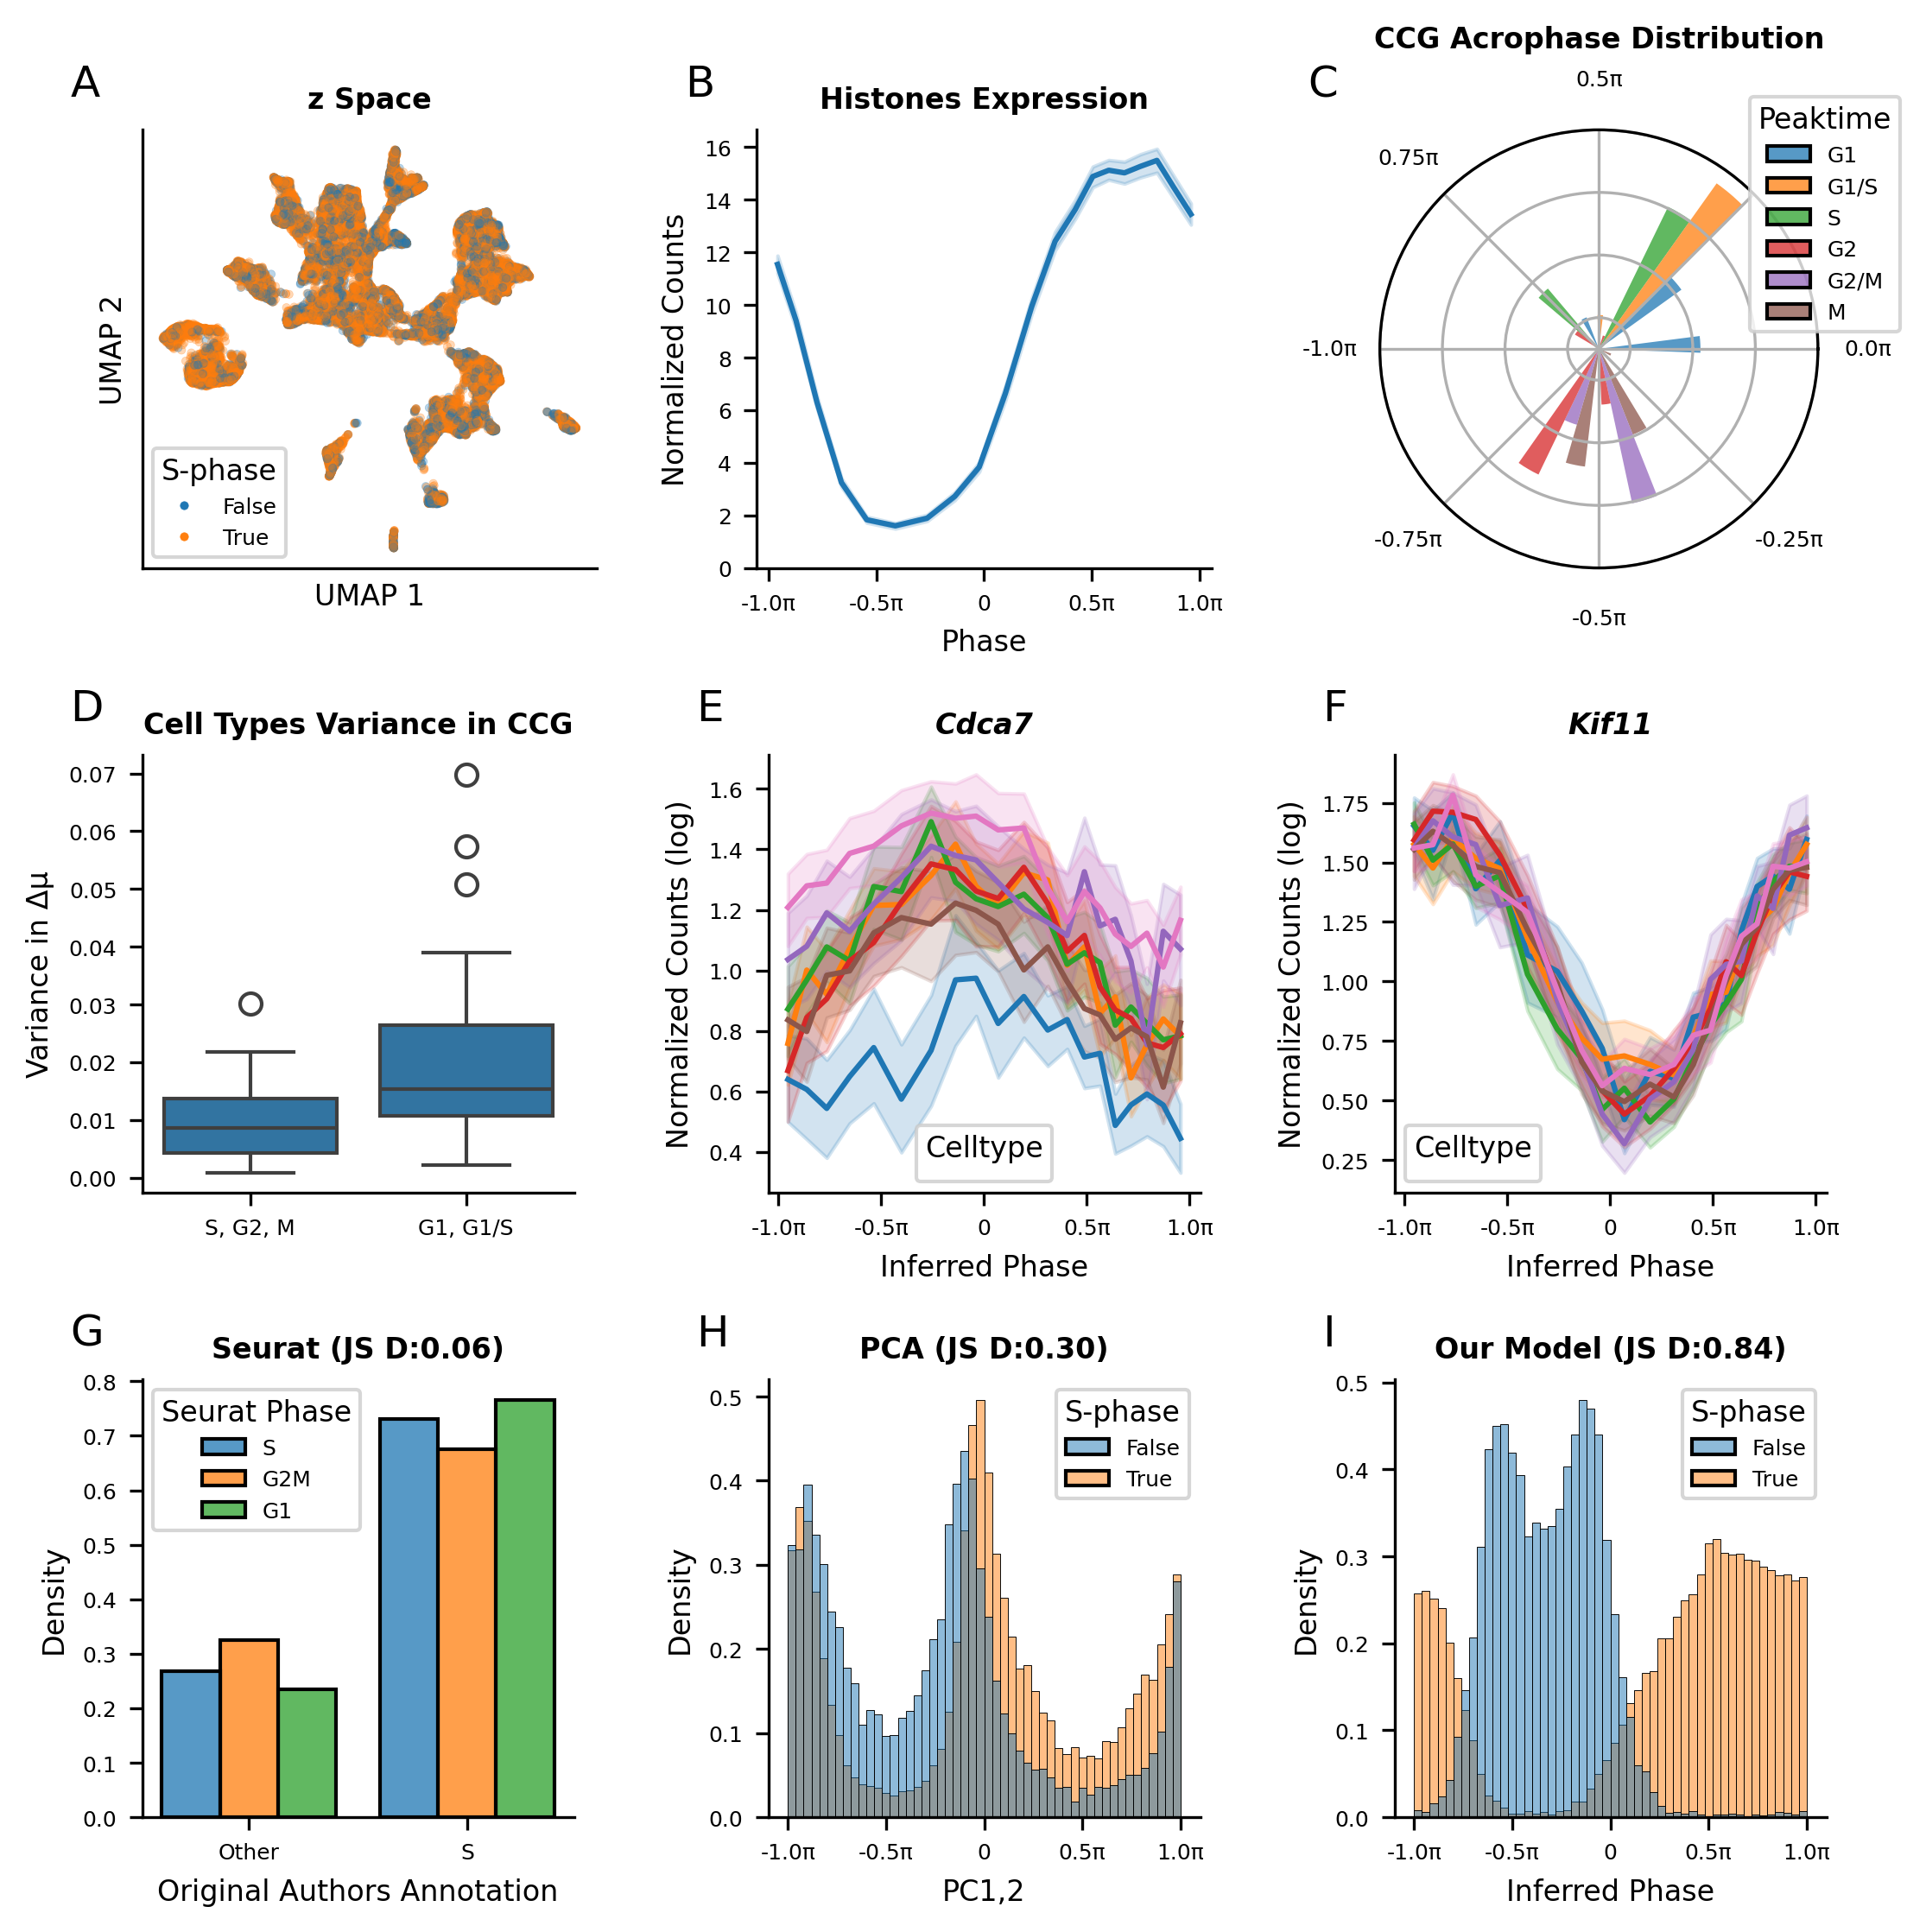

: 

In [ ]:
plot_helpers.label_panels_mosaic(fig, axs, mosaic)
plot_helpers.save_figure(
    fig, axs, "figure_S4_VASA", uncompressed_rows=[0], mosaic=mosaic, wpad=0.1
)